This file is loosely inspired by the tutorial based on:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>

Some of the code in this file is generated by ChatGPT

This file makes use of the MIT-BIH Database

# Dependencies

In [153]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import wfdb

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

import time
import csv
import os
import random

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

import re


# Load the dataset

The MIT-BIH dataset contains 48 half-hour samples of ECG recordings

Each recording corresponds to three raw files:

1. `.hea` describes the recording's sampling rate, channels, etc.
2. `.dat` are a sequence of 12-bit integers encoding the intensity at 360 Hz with a resolution of 1/200 mV
    - there are two channels, but only the first one is consistent
3. `.atr` includes the time stamp and type of each heartbeat

In [154]:
dl_path = "./raw_data/"
lof = []
#for p in os.listdir(dl_path):
#    if 'atr' in p:
#        lof.append(int(p.split('.')[0]))

In [238]:
# contains paced beats
excludedNames = [102, 104, 107, 217]

# set records to be included here
recordNames = [208]
for l in lof:
    if (l not in excludedNames):
        recordNames.append(l)
#recordNames = [100, 101, 103, 105, 106, 108, 109, 111, 112]
#recordNames = [100, 101]

print(recordNames)

# window size for each record
windowSize = 290

batch_size =  512
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")

seed = 22
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

[208]


In [239]:
numRec = len(recordNames)

for i in range(numRec):
    recordNames[i] = str(recordNames[i])

print("Number of records: %d" % numRec)

Number of records: 1


# Read the files

The `.dat` file's encoding is automatically converted to double floats in mV when we read it

The `.atr` is read into an object with an array of true labels and an array of time stamps

In [240]:
annos = [] # annotation
records = []

for i in range(numRec):
    annos.append(wfdb.rdann(dl_path + recordNames[i], 'atr'))
    records.append(wfdb.rdrecord(dl_path + recordNames[i]))

print(len(annos[i].sample), len(annos[i].symbol))
    
signals = []
for i in range(numRec):
    # we'll worry about quantization later in the code
    signals.append(records[i].p_signal.astype(np.float32))

3040 3040


## Heartbeat Segmentation

We want each heartbeat in the records to be one data point, those data points should then be shuffled (instead of being grouped by patient)

In [241]:
#for i in range(len(annos[0].symbol)):
#    if (annos[0].symbol[i] == "F"):
#        print(i)

In [242]:
# N:0 S:1 V:2 F:3 Q:4; 4 is unclassifiable
labelMap = {
    'N':0,'L':0,'R':0,'e':0,'j':0,
    'A':1,'a':1,'J':1,'S':1,
    'V':2,'E':2,
    'F':3,
    'Q':4,'/':4,'?':4,'f':4,'P':4,'t':4
}

In [243]:
beats = []
labelChars = [] # label still in strings
for i in range(numRec):
    for pos, label in zip(annos[i].sample, annos[i].symbol):
        if (label not in labelMap.keys()):
            continue
        winMin = pos - windowSize//2
        winMax = pos + windowSize//2
        if (winMin >=0 and winMax <= len(signals[i])): # this will sacrifice some signals
            segment = signals[i][pos - windowSize//2 : pos + windowSize//2, 0] # channel 0 only
            beats.append(segment)
            labelChars.append(label)

beats = np.stack(beats) # shape: total number of beats * window size
print("Shape of beats:", len(beats), len(beats[0]))

Shape of beats: 2953 290


AAMI suggests five categories out of the multitude of labels from MIT-BIH, we encode them into integers

In [244]:

print(labelChars[1750])
labels = [labelMap.get(_x, -1) for _x in labelChars]

print(set(labels))
#plt.plot(labels)
#plt.xlim(600, 650)
#plt.show()

F
{0, 1, 2, 3, 4}


20 290 20
{0, 1, 2, 3}
[3, 2, 0, 3, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 1, 2]


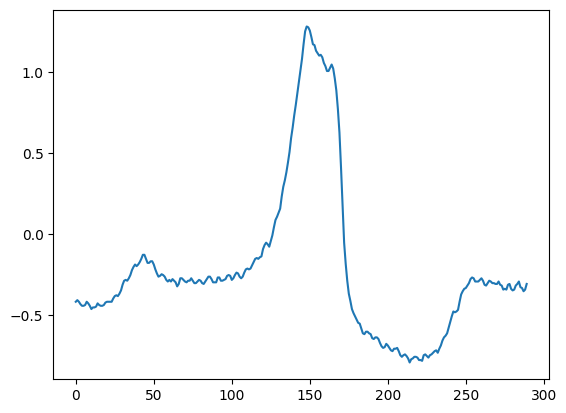

In [245]:
fLabels = []
fBeats = []

'''
for i in range(len(labels)-5):
    if (labels[i] != 0):
        for j in range(i - 5, i + 5):
            fLabels.append(labels[j])
            fBeats.append(beats[j])
labels = fLabels
beats = fBeats

'''
labels = labels[1750:1770]
beats = beats[1750:1770]


print(len(beats), len(beats[0]), len(labels))
print(set(labels))
print(labels)
plt.plot(beats[1])

## Spike Generation

In [246]:
def normalize(x):
    x_min = x.min()
    x_max = x.max()
    return (x - x_min) / (x_max - x_min + 1e-8)

### Derivative

Using the derivative is sometimes helpful

In [247]:
# by ChatGPT
def dvdt(x: torch.Tensor) -> torch.Tensor:
    if x.ndim != 3:
        raise ValueError(f"Expected a 3D tensor (time, batch, inputs), got {x.ndim}D.")
    
    dx = x[1:] - x[:-1]
    zero_frame = torch.zeros(1, *x.shape[1:], dtype=x.dtype, device=x.device)
    dx = torch.cat((dx, zero_frame), dim=0)
    return dx

### deltas

We can work with just the positive edge, or both

In [248]:
# expecting an input of num_steps x batch x 1
# returning either nxbx1 or nxbx2

# snnTorch: if (data[n+1] - data[n] > thr): spike
def delta_snt(data, deltaThr, negEdge=False):
    if (not negEdge):
        return spikegen.delta(data, threshold=deltaThr)
    
    spikeDataP = spikegen.delta(data, threshold=deltaThr)
    spikeDataN = spikegen.delta(-data, threshold=deltaThr)
    spikeData = torch.cat((spikeDataP, spikeDataN), dim=2)
    return spikeData

# alternative: if (data[n] - data[prevSpike] > thr): spike
def delta_alt(data, deltaThr, negEdge=False):
    if (not negEdge):
        spikes = torch.zeros_like(data)
        for b in range(data.size(1)):
            prevSpike = 0
            for n in range(data.size(0)):
                if ((data[n, b, 0] - data[prevSpike, b, 0]) > deltaThr):
                    spikes[n, b, 0] = 1
                    prevSpike = n
        return spikes
    else:
        # ChatGPT impl.
        timesteps, batches, inputs = data.shape

        # Initialize output spike signals with zeros
        pos_spikes = torch.zeros_like(data, device=device)
        neg_spikes = torch.zeros_like(data, device=device)
    
        data = data * 16384
        data = torch.round(data)
        data = data / 16384 
        
        # Initialize delta_sample as the first sample for each batch
        delta_sample = data[0].clone()
    
        for t in range(timesteps):
            x = data[t]
    
            # Positive spike detection
            pos_mask = x > delta_sample + deltaThr
            pos_spikes[t, pos_mask] = 1.0  # spike
            delta_sample[pos_mask] = x[pos_mask]
    
            # Negative spike detection
            neg_mask = x < delta_sample - deltaThr
            neg_spikes[t, neg_mask] = 1.0  # spike
            delta_sample[neg_mask] = x[neg_mask]
 
        spikeData = torch.cat((pos_spikes, neg_spikes), dim=2)
        return spikeData
        

## Dataset and Loader

In [251]:
def normalize(tensor):
    min_val = tensor.min()
    max_val = tensor.max()
    
    # Avoid division by zero if all values are equal
    if max_val == min_val:
        return torch.zeros_like(tensor)
    
    normalized = (tensor - min_val) / (max_val - min_val)
    return normalized

def normalize3(tensor, min_val, max_val):
    # Avoid division by zero if all values are equal
    if max_val == min_val:
        return torch.zeros_like(tensor)
    
    normalized = (tensor - min_val) / (max_val - min_val)
    return normalized

def tensor_to_csv(tensor: torch.Tensor, filepath: str):
    """
    Save a 2D PyTorch tensor to a CSV file.
    """
    tensor = tensor * 65536
    nr = tensor.detach().cpu().round().to(torch.int64).numpy()
    plt.plot(nr[1])
    plt.show()
    np.savetxt(filepath, nr, delimiter=",", fmt="%d")

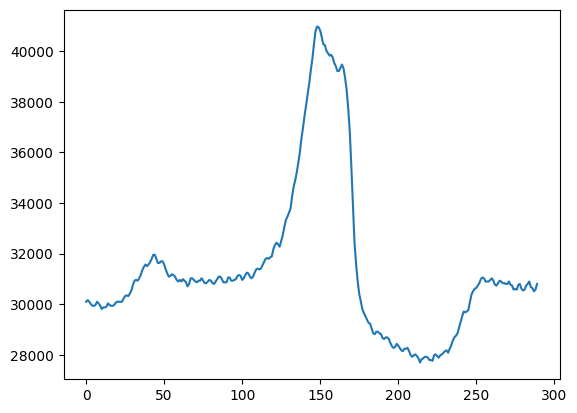

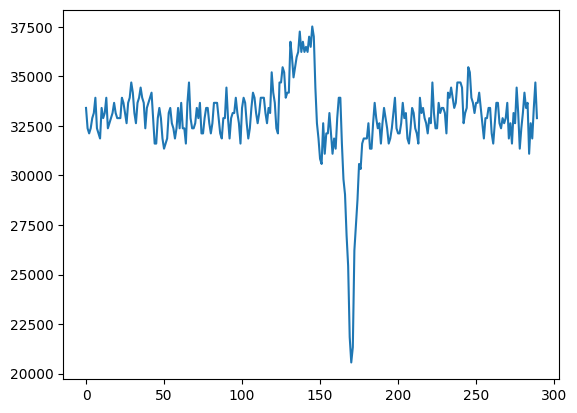

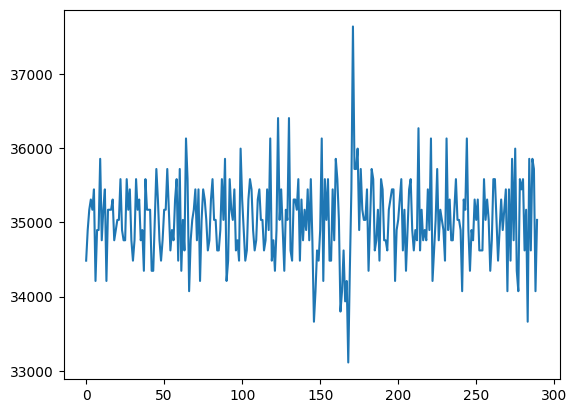

torch.Size([290, 20, 6]) torch.Size([20])


In [252]:
class Spike_Dataset(Dataset):
    def __init__(self, beatsT, labelsT, deltaThr1, deltaThr2,
                 t=torch.float32):
        self.labels = torch.tensor(labelsT, dtype=torch.long).to(device)

        data = torch.tensor(beatsT)
        self.beats = normalize(data)
        data = (data.unsqueeze(0)).permute(2, 1, 0)

        d = normalize3(data, -5.12, 5.115)
        ddt = normalize3(dvdt(data), -0.64, 0.635)
        ddt2 = normalize3(dvdt(dvdt(data)), -1.275, 1.11)

        tensor_to_csv(d.permute(2, 1, 0)[0], "s_d.csv")
        tensor_to_csv(ddt.permute(2, 1, 0)[0], "s_ddt.csv")
        tensor_to_csv(ddt2.permute(2, 1, 0)[0], "s_ddt2.csv")
        
        spikeData0 = delta_alt(d, deltaThr1, True)
        spikeData1 = delta_alt(ddt, deltaThr2, True)
        spikeData2 = delta_alt(ddt2, deltaThr2, True)
        spikeData = torch.cat((spikeData0, spikeData1, spikeData2),
                              dim=2)
        
        self.spikes = spikeData.to(device)
        
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.spikes[:, idx, :], self.labels[idx]
    def shapes(self):
        print(self.spikes.shape, self.labels.shape)
    def getBeat(self, idx):
        return self.beats[idx]


dataset = Spike_Dataset(beats, labels, 0.003, 0.006)
dataset.shapes()

loader = DataLoader(dataset, batch_size=batch_size,
                          shuffle=False, drop_last=False)


# Define the Network(s)

## SNN_Baseline

In [212]:
# accepts a tensor of num_steps×batchx1
class SNN_Baseline(nn.Module):
    def __init__(self, beta=0.95, qbits = 8, fbits = 6):
        super().__init__()
        self.name = "SNN_Baseline"
        
        # Temporal Dynamics
        self.beta = beta

        # ensure all internal operations are done on fixed point
        self.quant = False
        # the total number of bits we can use
        self.qbits = qbits
        self.fbits = fbits # the number of bits representing fractions
        
        # Network Architecture
        num_inputs = 2
        num_outputs = 5 # five classes

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, 64, bias=False)
        self.lif1 = snn.Leaky(beta=self.beta)
        self.fc2 = nn.Linear(64, num_outputs, bias=False)
        self.lif2 = snn.Leaky(beta=self.beta)

    # quantize any tensor according to the model's rules
    def quantize(self, x):
        if (not self.quant):
            return x
        # e.g. quantize 1.1 with 4 bits incl. 2 fraction bits, 2's complement:
        # 1. find the upper and lower bounds 0b(01.11)=1.75; 0b(10.00)=-2
        # 2. clamp it if necessary
        # 3. scale it by 2^3=8 => 1.1*8=8.8
        # 4. round it to a whole number: round(8.8)=9=0b1001
        # 5. scale back 9/8=1.125=0b(1.001) which is the closest we can do
        # boundary check        
        scale = 1 << self.fbits
        
        ub = ((1 << (self.qbits-1))-1) / scale
        lb = ((1 << (self.qbits-1))*-1)/ scale
        x = torch.clamp(x, lb, ub)
        
        x = x *scale 
        x = torch.round(x)
        
        x = x / scale

        return x

    # toggle quantized mode, irreversible for now
    def quant_mode(self):
        if (not self.quant):
            self.quant = True
            self.fc1.weight.data = self.quantize(self.fc1.weight.data)
            self.fc2.weight.data = self.quantize(self.fc2.weight.data)

    # can report the hidden value for logging
    def forward(self, x, num_steps, hidden=False):
        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        mem1_rec = []
        
        # Record the final layer
        spkx_rec = []
        memx_rec = []

        # Feed in the spikes of the entire batch at a given time step in parallel
        for step in range(num_steps):
            # the weights are already quant'd, no need to quant spikes
            cur1 = self.fc1(x[step])
            # the resulting multiple is still quant'd
            cur1 = torch.clamp(cur1, 0, None) # room for optimisation for quant

            # potential quant bug: depending on how the currents are summed up they
            # will have the same precision, but can exceed the upper bound
            spk1, mem1 = self.lif1(cur1, mem1)
            # consistently quant mem1 after use
            mem1 = self.quantize(mem1)
            cur2 = self.fc2(spk1)
            cur2 = torch.clamp(cur2, 0, None)
            
            spk2, mem2 = self.lif2(cur2, mem2)
            # consistently quant mem2 after use
            mem2 = self.quantize(mem2)
            
            spkx_rec.append(spk2)
            memx_rec.append(mem2)

            
            if (hidden):
                mem1_rec.append(mem1)
        
        if (hidden):
            mem1_rec = torch.stack(mem1_rec, dim=0)
        else:
            mem1_rec = None

        return (torch.stack(spkx_rec, dim=0),
                torch.stack(memx_rec, dim=0),
                mem1_rec)

## SNN_Big

In [213]:
# accepts a tensor of num_steps×batchx1
class SNN_Big(nn.Module):
    def __init__(self, beta=0.95, qbits = 8, fbits = 6, num_inputs_p = 2):
        super().__init__()
        self.name = "SNN_Big"
        
        # Temporal Dynamics
        self.beta = beta

        # ensure all internal operations are done on fixed point
        self.quant = False
        # the total number of bits we can use
        self.qbits = qbits
        self.fbits = fbits # the number of bits representing fractions
        
        # Network Architecture
        num_inputs = num_inputs_p
        num_outputs = 5 # five classes

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, 64, bias=False)
        self.lif1 = snn.Leaky(beta=self.beta, reset_mechanism='zero')
        self.fc2 = nn.Linear(64, 128, bias=False)
        self.lif2 = snn.Leaky(beta=self.beta, reset_mechanism='zero')
        self.fc3 = nn.Linear(128, 64, bias=False)
        self.lif3 = snn.Leaky(beta=self.beta, reset_mechanism='zero')
        self.fc4 = nn.Linear(64, num_outputs, bias=False)
        self.lif4 = snn.Leaky(beta=self.beta, reset_mechanism='zero')


    # quantize any tensor according to the model's rules
    def quantize(self, x):
        if (not self.quant):
            return x
        # e.g. quantize 1.1 with 4 bits incl. 2 fraction bits, 2's complement:
        # 1. find the upper and lower bounds 0b(01.11)=1.75; 0b(10.00)=-2
        # 2. clamp it if necessary
        # 3. scale it by 2^3=8 => 1.1*8=8.8
        # 4. round it to a whole number: round(8.8)=9=0b1001
        # 5. scale back 9/8=1.125=0b(1.001) which is the closest we can do
        # boundary check        
        scale = 1 << self.fbits
        
        ub = ((1 << (self.qbits-1))-1) / scale
        lb = ((1 << (self.qbits-1))*-1)/ scale
        x = torch.clamp(x, lb, ub)
        
        x = x *scale 
        x = torch.round(x)
        
        x = x / scale

        return x

    # toggle quantized mode, irreversible for now
    def quant_mode(self):
        if (not self.quant):
            self.quant = True
            self.fc1.weight.data = self.quantize(self.fc1.weight.data)
            self.fc2.weight.data = self.quantize(self.fc2.weight.data)
            self.fc3.weight.data = self.quantize(self.fc3.weight.data)
            self.fc4.weight.data = self.quantize(self.fc4.weight.data)

    # can report the hidden value for logging
    def forward(self, x, num_steps, hidden=False):
        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()

        mem1_rec = []
        
        # Record the final layer
        spkx_rec = []
        memx_rec = []

        # Feed in the spikes of the entire batch at a given time step in parallel
        for step in range(num_steps):
            # the weights are already quant'd, no need to quant spikes
            cur1 = self.fc1(x[step])
            # the resulting multiple is still quant'd
            #cur1 = torch.clamp(cur1, 0, None) # room for optimisation for quant
            # potential quant bug: depending on how the currents are summed up they
            # will have the same precision, but can exceed the upper bound
            spk1, mem1 = self.lif1(cur1, mem1)
            # consistently quant mem1 after use
            mem1 = self.quantize(mem1)
            
            cur2 = self.fc2(spk1)
            #cur2 = torch.clamp(cur2, 0, None)
            spk2, mem2 = self.lif2(cur2, mem2)
            # consistently quant mem2 after use
            mem2 = self.quantize(mem2)
            
            cur3 = self.fc3(spk2)
            #cur3 = torch.clamp(cur3, 0, None)
            spk3, mem3 = self.lif3(cur3, mem3)
            # consistently quant mem3 after use
            mem3 = self.quantize(mem3)

            cur4 = self.fc4(spk3)
            #cur4 = torch.clamp(cur4, 0, None)
            spk4, mem4 = self.lif4(cur4, mem4)
            # consistently quant mem4 after use
            mem4 = self.quantize(mem4)
            
            spkx_rec.append(spk4)
            memx_rec.append(mem4)

            
            if (hidden):
                mem1_rec.append(mem1)
        
        if (hidden):
            mem1_rec = torch.stack(mem1_rec, dim=0)
        else:
            mem1_rec = None

        return (torch.stack(spkx_rec, dim=0),
                torch.stack(memx_rec, dim=0),
                mem1_rec)


# Inferencing 

In [214]:
net = SNN_Big(0.9375, 12, 4, 6).to(device)
net.load_state_dict(torch.load("cps/net_premier.pth"))

trues = {0:0, 1:0, 2:0, 3:0, 4:0}
totals = {0:0, 1:0, 2:0, 3:0, 4:0}
c = 0
with torch.no_grad():
    net.eval()
    net.quant_mode()
    counter = 0
    for data, targets in loader:
        data = data.to(device)
        targets = targets.to(device)

        data = data.permute(1, 0, 2)
        # spikeData should be in (num_steps)xbatchxinputs

        # forward pass
        test_spk, mem_rec, mem1_rec = net(data, 290, True)

        # sample plots
        if (random.randint(0, 10000) < 800) and False:
            pass

    
        #print(test_spk.sum(dim=0))
        # calculate total accuracy
        _, predicted = test_spk.sum(dim=0).max(1)

        for i in range(len(predicted)):
            trues[int(targets[i])] += int(predicted[i] == targets[i])
            totals[int(targets[i])] += 1
            c += 1
            print(c, predicted[i], targets[i], int(predicted[i] == targets[i]))

print(trues)
print(totals)


1 tensor(3, device='cuda:0') tensor(3, device='cuda:0') 1
2 tensor(2, device='cuda:0') tensor(2, device='cuda:0') 1
3 tensor(0, device='cuda:0') tensor(0, device='cuda:0') 1
4 tensor(3, device='cuda:0') tensor(3, device='cuda:0') 1
5 tensor(2, device='cuda:0') tensor(2, device='cuda:0') 1
6 tensor(0, device='cuda:0') tensor(0, device='cuda:0') 1
7 tensor(2, device='cuda:0') tensor(2, device='cuda:0') 1
8 tensor(0, device='cuda:0') tensor(0, device='cuda:0') 1
9 tensor(0, device='cuda:0') tensor(0, device='cuda:0') 1
10 tensor(2, device='cuda:0') tensor(2, device='cuda:0') 1
11 tensor(2, device='cuda:0') tensor(2, device='cuda:0') 1
12 tensor(0, device='cuda:0') tensor(0, device='cuda:0') 1
13 tensor(0, device='cuda:0') tensor(0, device='cuda:0') 1
14 tensor(2, device='cuda:0') tensor(2, device='cuda:0') 1
15 tensor(0, device='cuda:0') tensor(0, device='cuda:0') 1
16 tensor(0, device='cuda:0') tensor(0, device='cuda:0') 1
17 tensor(2, device='cuda:0') tensor(2, device='cuda:0') 1
18 ten

In [208]:
print(net.fc1.weight)

Parameter containing:
tensor([[ -6.8750,  -5.1250,   0.6875,   1.0000,   0.1875,   0.6250],
        [  2.8125,  -0.2500,   0.0000,  -0.9375,   0.0625,  -0.4375],
        [  0.3750,   1.9375,  -0.6250,  -0.0625,  -0.7500,   0.3750],
        [  0.3750,   4.2500,  -2.1250,  -0.1875,  -0.5000,  -2.8750],
        [ -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000],
        [  1.6250,  -0.7500,   0.2500,  -0.0000,   0.2500,   0.1875],
        [  3.3125,  -3.6875,   0.1875,   0.3125,   0.4375,  -1.0625],
        [ -0.3750,   3.5000,  -1.8750,  -0.2500,  -0.6250,  -0.0625],
        [ -0.6250,  -2.8125,   0.8125,   1.3125,   0.0625,   0.3750],
        [  2.2500,  -2.2500,  -0.5000,  -0.3750,  -0.0000,  -0.3125],
        [  0.7500,   4.1875,  -0.2500,  -0.4375,  -1.0000,   0.6250],
        [ -1.6875,   0.0000,   8.1875,   0.5625,  -0.5625,   1.0000],
        [  3.7500,  -7.3125,   1.0000,  -0.3125,   0.6875,  -0.0000],
        [ -7.0000,   3.5625,  -0.0625,  -0.9375,  -0.6875,   1.3125]